# The New Science of Hitting
FiveThirtyEight's [The New Science of Hitting](https://fivethirtyeight.com/features/the-new-science-of-hitting/) serves as a nice primer on how Statcast data is giving us a new glimpse into the game's inner workings. This notebook will serve as an example of how to re-create their analysis and work with Statcast data. 

In [99]:
#imports
from pybaseball import statcast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### First, collect two months worth of pitch-level data from Statcast

In [100]:
# collect Statcast data on all pitches from the months of May and June
data = statcast('2017-05-01', '2017-06-30')
print(data.shape)

This is a large query, it may take a moment to complete
Completed sub-query from 2017-05-01 to 2017-05-06
Completed sub-query from 2017-05-07 to 2017-05-12
Completed sub-query from 2017-05-13 to 2017-05-18
Completed sub-query from 2017-05-19 to 2017-05-24
Completed sub-query from 2017-05-25 to 2017-05-30
Completed sub-query from 2017-05-31 to 2017-06-05
Completed sub-query from 2017-06-06 to 2017-06-11
Completed sub-query from 2017-06-12 to 2017-06-17
Completed sub-query from 2017-06-18 to 2017-06-23
Completed sub-query from 2017-06-24 to 2017-06-29
Completed sub-query from 2017-06-30 to 2017-06-30
(248872, 79)


###Not every pitch results in contact with the ball, so let's drop all observations where the metrics we care about have NaNs for their value.

In [101]:
# drop rows where the data we need is missing
pd.options.mode.chained_assignment = None
data2 = data[pd.notnull(data['launch_angle'])]
data2 = data2[pd.notnull(data['launch_speed'])]
data2 = data2[pd.notnull(data['estimated_ba_using_speedangle'])]
print(data2.shape)

(68983, 79)


### Now for the fun part: plot a batted ball's probability of becoming a hit as a function of its launch angle and exit velocity.

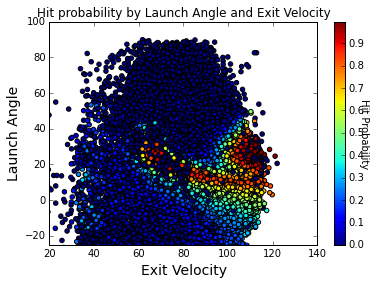

In [102]:
plt.scatter(data2['launch_speed'], data2['launch_angle'], c=data2['estimated_ba_using_speedangle'])
plt.xlabel('Exit Velocity', fontsize=14)
plt.ylabel('Launch Angle', fontsize=14)
plt.colorbar().set_label('Hit Probability', rotation=270)
plt.xlim(20, 140)
plt.ylim(-25, 100)
plt.title("Hit probability by Launch Angle and Exit Velocity");

As you can see, the "sweet spot" where these two metrics are just right for producing a hit is not a simple blob on the graph as one might expect! In fact, there seem to be two distinct patterns happening here. Let's take a look at this same chart for home runs only and see if those are responsible for the differing patterns.

In [103]:
# now just the home runs 
data2['hr'] = 0
data2.loc[data2['events'] == 'home_run', 'hr'] = 1
data3 = data2.loc[data2['hr'] ==1]
data3.shape

(2161, 80)

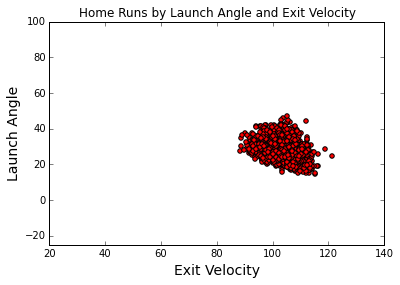

In [104]:
plt.scatter(data3['launch_speed'], data3['launch_angle'],c='red')
plt.xlabel('Exit Velocity', fontsize=14)
plt.ylabel('Launch Angle', fontsize=14)
plt.xlim(20, 140)
plt.ylim(-25, 100)
plt.title("Home Runs by Launch Angle and Exit Velocity");

So there you have it. From the two patterns observed when plotting hit probability against exit velocity and launch angle, the round cluster around 115mph speed and 30 degrees launch angle represents mostly home runs, while the other pattern observed is within-the-park hits. 

### Another question we can ask: is it always better to hit the ball harder?
Here we will look at a few metrics, but most importantly expected wOBA (weighted on base average), as they vary by hit speed. First, let's break hit speed into five evenly spaced bins and see how a few variables look when broken down by exit velocity. 

In [105]:
#create launch speed bins
bins = np.linspace(data2.launch_speed.min(), data2.launch_speed.max(), 5)
groups = data2.groupby(np.digitize(data2.launch_speed, bins))

# take alook at how various features vary with launch speed
print groups.mean() # Also could do "groups.aggregate(np.mean)"

          index  release_speed  release_pos_x  release_pos_z         batter  \
1  10143.852113      88.497183      -0.860805       5.814508  544731.204225   
2  12076.895199      87.581754      -0.888354       5.878141  528640.873106   
3  12047.603634      89.524192      -0.953900       5.881568  526689.249588   
4  12055.516438      89.215854      -0.972775       5.889214  524962.497995   
5   4628.000000      95.900000      -1.212300       5.523000  543257.000000   

         pitcher  spin_dir  spin_rate_deprecated  break_angle_deprecated  \
1  533116.774648       NaN                   NaN                     NaN   
2  528990.296700       NaN                   NaN                     NaN   
3  531408.936784       NaN                   NaN                     NaN   
4  531612.102185       NaN                   NaN                     NaN   
5  592390.000000       NaN                   NaN                     NaN   

   break_length_deprecated    ...     estimated_ba_using_speedangle 

There are definitely some patterns there. To take a closer look at the metric of interest, let's use a few more bins and graph the expected weighted on base average value of a hit against its exit velocity. This should give a rough answer as to whether it's always better to hit the ball harder. 

In [106]:
# re-bin with a value more useful for plotting
bins = np.linspace(data2.launch_speed.min(), data2.launch_speed.max(), 30)
groups = data2.groupby(np.digitize(data2.launch_speed, bins))
bin_woba = groups['estimated_woba_using_speedangle'].mean()

(40, 120)

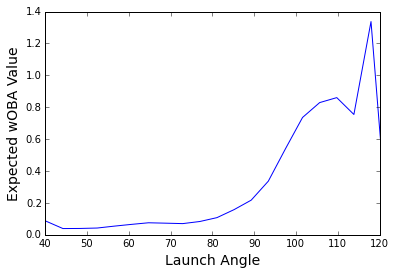

In [107]:
plt.plot(bins,bin_woba)
plt.xlabel('Launch Angle', fontsize=14)
plt.ylabel('Expected wOBA Value', fontsize=14)
plt.xlim(40,120)

So, while it's usually better to hit the ball harder, there is a slight downward "dip" in the graph. This most likely represents the fly ball zone, where the ball has been hit hard enogh to get past the infield and gain some air, but not hard enough to make it past the fences. 

In general, however, this confirms the trend we would expect. Harder-hit balls tend to give batters more bases. 